<a href="https://colab.research.google.com/github/eridanletalis/GB_nn/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Начнём решать задачу с загрузки библиотек и датасета FASHION-MNIST

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


Словарь-подсказка для меток


In [3]:
fashion_dict = {
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

In [4]:
import numpy as np
import pandas as pd

In [5]:
pd.DataFrame(y_train).value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

In [6]:
pd.DataFrame(y_test).value_counts()

9    1000
8    1000
7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
1    1000
0    1000
dtype: int64

In [7]:
# проверить разницу между преобразованием в 0..1 и -0.5..0.5


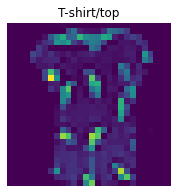

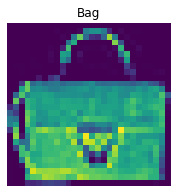

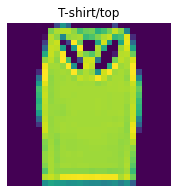

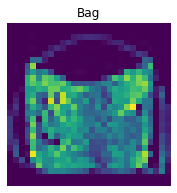

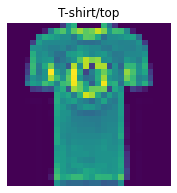

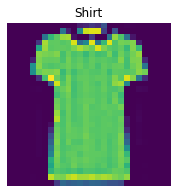

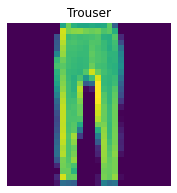

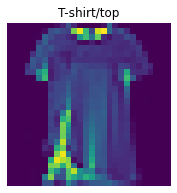

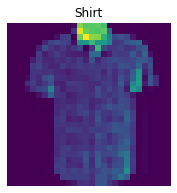

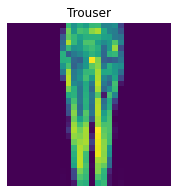

In [8]:
# посмотрим на 10 случайных элементов картинок для тренировки
import matplotlib.pyplot as plt

for i in np.random.choice(len(x_train), 10, replace=False):
  plt.figure(figsize=(3, 3))
  plt.imshow(x_train[i].astype("uint8"))
  plt.title(fashion_dict[y_train[i]])
  _ = plt.axis("off")

In [9]:
# Параметры данных
num_classes = 10
input_shape = (28, 28, 1)

# Масштабирование к 0..1
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Предобработка изображений
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# Преобразование входного формата
train_images = x_train.reshape((-1, 784))
test_images = x_test.reshape((-1, 784))

# Получение метрик как списка
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [10]:
# Простая модель, как с урока
model = keras.Sequential(
    [
        layers.Dense(128, activation='relu', input_shape=(784,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation="softmax")
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 104,938
Trainable params: 104,938
Non-trainable params: 0
_________________________________________________________________


In [11]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(train_images, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)


Epoch 1/15
375/375 [==============================] - 2s 4ms/step - loss: 0.8459 - accuracy: 0.7212 - val_loss: 0.4525 - val_accuracy: 0.8413
Epoch 2/15
375/375 [==============================] - 1s 3ms/step - loss: 0.4285 - accuracy: 0.8485 - val_loss: 0.4001 - val_accuracy: 0.8568
Epoch 3/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3712 - accuracy: 0.8677 - val_loss: 0.3778 - val_accuracy: 0.8627
Epoch 4/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3483 - accuracy: 0.8718 - val_loss: 0.3541 - val_accuracy: 0.8737
Epoch 5/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3204 - accuracy: 0.8829 - val_loss: 0.3498 - val_accuracy: 0.8751
Epoch 6/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3076 - accuracy: 0.8877 - val_loss: 0.3333 - val_accuracy: 0.8812
Epoch 7/15
375/375 [==============================] - 1s 3ms/step - loss: 0.2943 - accuracy: 0.8919 - val_loss: 0.3305 - val_accuracy: 0.8804
Epoch 

In [12]:
score = model.evaluate(test_images, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Test loss: 0.35079655051231384
Test accuracy: 0.8763999938964844


In [13]:
score = model.evaluate(train_images, y_train, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Test loss: 0.23346850275993347
Test accuracy: 0.9141333103179932


План эксперимента 1.
Соберём функцию, которая будет заполнять для нас статистику для сетей с разными параметрами и разными начальными весами (для усреднения аккуратности и вычисления дисперсии)

12 моделей имеют два скрытых слоя, без учёта выходного, с разным количеством нейронов: (32, 16), (64, 16), (32, 32), (64,32), (128, 16), (128, 32), (128,64), (256, 32), (256, 64), (256, 128), (256, 256)

Каждая сеть будет вычислена 10 раз, результаты сведены в таблицу.
Функции активации, оптимайзер и функция потерь будут идентичны:
для первого слоя - релу, для второго - сигмоида, для третьего - софтмакс


In [21]:
from datetime import datetime
from tensorflow.keras import initializers

In [15]:
nets = ("32-16", "64-16", "32-32","64-32", "128-16", "128-32", "128-64",
        "256-16", "256-32","256-64","256-128","256-256")
test_1a_df = pd.DataFrame(columns=nets)
test_1b_df = pd.DataFrame(columns=nets)

In [16]:
# test_1a_df.loc[0,"32-16"] = 1 # аккуратность для трейна
# test_1b_df.loc[0,"32-16"] = 1 # аккуратность для теста

In [17]:
columns_1 = ("name", "1st_layer_cnt", "2nd_layer_cnt", "acc_trn", "acc_tst", "acc_trn_disp", "acc_tst_disp")
models = pd.DataFrame(columns=columns_1)

In [18]:

models.loc[0] = (["32-16", 32, 16, 0,0,0,0])
models.loc[1] = (["64-16", 64, 16, 0,0,0,0])
models.loc[2] = (["32-32", 32, 32, 0,0,0,0])
models.loc[3] = (["64-32", 64, 32, 0,0,0,0])
models.loc[4] = (["128-16", 128, 16, 0,0,0,0])
models.loc[5] = (["128-32", 128, 32, 0,0,0,0])
models.loc[6] = (["128-64", 128, 64, 0,0,0,0])
models.loc[7] = (["256-16", 256, 16, 0,0,0,0])
models.loc[8] = (["256-32", 256, 32, 0,0,0,0])
models.loc[9] = (["256-64", 256, 64, 0,0,0,0])
models.loc[10] = (["256-128", 256, 128, 0,0,0,0])
models.loc[11] = (["256-256", 256, 256, 0,0,0,0])

In [19]:
models

,name,1st_layer_cnt,2nd_layer_cnt,acc_trn,acc_tst,acc_trn_disp,acc_tst_disp
0,32-16,32,16,0,0,0,0
1,64-16,64,16,0,0,0,0
2,32-32,32,32,0,0,0,0
3,64-32,64,32,0,0,0,0
4,128-16,128,16,0,0,0,0
5,128-32,128,32,0,0,0,0
6,128-64,128,64,0,0,0,0
7,256-16,256,16,0,0,0,0
8,256-32,256,32,0,0,0,0
9,256-64,256,64,0,0,0,0


In [ ]:
for i in range(10):
  for model in models.itertuples():
    print("Обработка модели ", model[1], "Итерация ", i)
    model_1 = keras.Sequential(
    [
        layers.Dense(model[2], activation='relu', input_shape=(784,),
                    kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                  stddev=0.15, 
                                      seed=int(datetime.now().timestamp()))),
        layers.Dense(model[3], activation='sigmoid',
                    kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                  stddev=0.15, 
                                      seed=int(datetime.now().timestamp()))),
        layers.Dense(num_classes, activation="softmax")
    ]
  )
    model_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model_1.fit(train_images, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
    test_1a_df.loc[i, model[1]] =  model_1.evaluate(train_images, y_train, verbose=0)[1] # аккуратность для трейна
    test_1b_df.loc[i, model[1]] = model_1.evaluate(test_images, y_test, verbose=0)[1] # аккуратность для теста


In [23]:
test_1b_df

,32-16,64-16,32-32,64-32,128-16,128-32,128-64,256-16,256-32,256-64,256-128,256-256
0,0.865,0.8671,0.8681,0.8759,0.8759,0.8772,0.8807,0.8851,0.8806,0.8829,0.8841,0.8868
1,0.8622,0.8711,0.8636,0.8717,0.8806,0.8814,0.8826,0.8841,0.8819,0.8816,0.8854,0.8885
2,0.8685,0.8719,0.8647,0.8777,0.8782,0.8801,0.8783,0.8765,0.8826,0.8844,0.8922,0.8812
3,0.8622,0.8699,0.8656,0.8765,0.8807,0.8821,0.8812,0.8826,0.8791,0.8851,0.8838,0.8854
4,0.8632,0.8699,0.8665,0.8721,0.8811,0.8769,0.8804,0.8782,0.8761,0.8853,0.8859,0.8911
5,0.8645,0.8732,0.8691,0.877,0.881,0.8812,0.8791,0.8741,0.8851,0.8863,0.8891,0.8825
6,0.8608,0.8711,0.8704,0.8751,0.8758,0.8793,0.8851,0.8801,0.8874,0.8804,0.8895,0.8881
7,0.8675,0.8699,0.8657,0.8767,0.8817,0.8777,0.8792,0.8844,0.8839,0.8878,0.883,0.8878
8,0.8688,0.8725,0.8699,0.8735,0.8734,0.8804,0.8832,0.881,0.8829,0.8899,0.8857,0.891
9,0.8617,0.8714,0.8678,0.8787,0.8806,0.8817,0.8808,0.8803,0.8829,0.8884,0.8845,0.881


In [32]:
test_1a_df

,32-16,64-16,32-32,64-32,128-16,128-32,128-64,256-16,256-32,256-64,256-128,256-256
0,0.889433,0.897717,0.891167,0.90525,0.912467,0.916217,0.919617,0.920867,0.919933,0.92655,0.927933,0.933783
1,0.884117,0.900783,0.8877,0.898967,0.914433,0.918183,0.91755,0.924283,0.925,0.92495,0.92625,0.937
2,0.889617,0.899417,0.888183,0.902583,0.910717,0.916383,0.9175,0.916717,0.923533,0.9272,0.93655,0.9252
3,0.888467,0.90085,0.890317,0.905517,0.912167,0.916317,0.9176,0.923417,0.91835,0.92965,0.92525,0.935217
4,0.88495,0.897483,0.891283,0.9018,0.913767,0.91325,0.91945,0.917683,0.919533,0.927967,0.92955,0.937317
5,0.888933,0.900817,0.891883,0.902333,0.914167,0.91615,0.912317,0.911683,0.9255,0.92825,0.93565,0.933183
6,0.883383,0.9003,0.893533,0.90375,0.9094,0.915667,0.922483,0.918533,0.9256,0.922333,0.93385,0.9365
7,0.892883,0.895483,0.8901,0.90255,0.91785,0.915483,0.916117,0.9206,0.92345,0.928917,0.931767,0.939217
8,0.8912,0.899417,0.893183,0.9035,0.90805,0.914967,0.9195,0.91805,0.925317,0.931733,0.931467,0.94025
9,0.886017,0.902333,0.893517,0.907533,0.913533,0.914917,0.9191,0.91895,0.927367,0.93085,0.92795,0.9296


In [51]:
models["acc_trn"] = test_1a_df.astype(np.float64).describe().T["mean"].values
models["acc_trn_disp"] = test_1a_df.astype(np.float64).describe().T["std"].values
models["acc_tst"] = test_1b_df.astype(np.float64).describe().T["mean"].values
models["acc_tst_disp"] = test_1b_df.astype(np.float64).describe().T["std"].values

In [52]:
models

,name,1st_layer_cnt,2nd_layer_cnt,acc_trn,acc_tst,acc_trn_disp,acc_tst_disp
0,32-16,32,16,0.887900,0.86444,0.003151,0.002935
1,64-16,64,16,0.899460,0.87080,0.002034,0.001717
2,32-32,32,32,0.891087,0.86714,0.002066,0.002280
3,64-32,64,32,0.903378,0.87549,0.002354,0.002359
4,128-16,128,16,0.912655,0.87890,0.002794,0.002896
5,128-32,128,32,0.915753,0.87980,0.001276,0.001935
6,128-64,128,64,0.918123,0.88106,0.002679,0.002077
7,256-16,256,16,0.919078,0.88064,0.003575,0.003594
8,256-32,256,32,0.923358,0.88225,0.003049,0.003143
9,256-64,256,64,0.927840,0.88521,0.002781,0.003023


На тесте у всех моделей примерно одинаковые средние значения аккуратности. Поэтому посмотрим на разброс.


In [56]:
models.sort_values(by=['acc_tst_disp', 'acc_trn_disp'], ascending=True)

,name,1st_layer_cnt,2nd_layer_cnt,acc_trn,acc_tst,acc_trn_disp,acc_tst_disp
1,64-16,64,16,0.899460,0.87080,0.002034,0.001717
5,128-32,128,32,0.915753,0.87980,0.001276,0.001935
6,128-64,128,64,0.918123,0.88106,0.002679,0.002077
2,32-32,32,32,0.891087,0.86714,0.002066,0.002280
3,64-32,64,32,0.903378,0.87549,0.002354,0.002359
4,128-16,128,16,0.912655,0.87890,0.002794,0.002896
0,32-16,32,16,0.887900,0.86444,0.003151,0.002935
10,256-128,256,128,0.930622,0.88632,0.003892,0.002971
9,256-64,256,64,0.927840,0.88521,0.002781,0.003023
8,256-32,256,32,0.923358,0.88225,0.003049,0.003143


Модель 64-16 имеет наименьший разброс на тесте, что может говорить о большей устойчивости модели при обучении с разными стартовыми весами. Также значения аккуратности на тесте и на трейне примерно одинаковые, можно сделать вывод о том, что модель не плохо обобщает, а не старается "подстроиться" под тест. В противовес можно выделить модель 256-256. Она имеет большую разницу аккуратности на трейне и тесте, кроме того, высокий разброс "аккуратностей". Я бы предположил, что такая модель склонна переобучаться и её адекватность сильно зависит от стартовых условий. 



In [116]:
nets2 = ("128-64-32", "64-64-32-32-32", "64-64-64-64-64-64-64-64-64",
         "256-256-256-256-256-256-256-256-256-256")
test_2a_df = pd.DataFrame(columns=nets2)
test_2b_df = pd.DataFrame(columns=nets2)

Список моделей для экспеориментов в переменной nets2

In [ ]:
for i in range(10):
  model_21_name = nets2[0]
  print("Работает модель ", model_21_name, " Итерация ", i)
  model_21 = keras.Sequential(
  [
      layers.Dense(128, activation='relu', input_shape=(784,),
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(64, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(32, activation='relu',
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(num_classes, activation="softmax")
  ]
  )

  model_21.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model_21.fit(train_images, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
  test_2a_df.loc[i, model_21_name] =  model_21.evaluate(train_images, y_train, verbose=0)[1] # аккуратность для трейна
  test_2b_df.loc[i, model_21_name] = model_21.evaluate(test_images, y_test, verbose=0)[1] # аккуратность для теста


  model_22_name = nets2[1]
  print("Работает модель ", model_22_name, " Итерация ", i)
  model_22 = keras.Sequential(
  [
      layers.Dense(64, activation='relu', input_shape=(784,),
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(64, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),      
      layers.Dense(32, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(32, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(32, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(num_classes, activation="softmax")
  ]
  )

  model_22.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model_22.fit(train_images, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
  test_2a_df.loc[i, model_22_name] =  model_22.evaluate(train_images, y_train, verbose=0)[1] # аккуратность для трейна
  test_2b_df.loc[i, model_22_name] = model_22.evaluate(test_images, y_test, verbose=0)[1] # аккуратность для теста

  model_23_name = nets2[2]
  print("Работает модель ", model_23_name, " Итерация ", i)
  model_23 = keras.Sequential(
  [
      layers.Dense(64, activation='relu', input_shape=(784,),
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(64, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),      
      layers.Dense(64, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(64, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(64, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
        layers.Dense(64, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),      
      layers.Dense(64, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(64, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(64, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(num_classes, activation="softmax")
  ]
  )

  model_23.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model_23.fit(train_images, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
  test_2a_df.loc[i, model_23_name] =  model_23.evaluate(train_images, y_train, verbose=0)[1] # аккуратность для трейна
  test_2b_df.loc[i, model_23_name] = model_23.evaluate(test_images, y_test, verbose=0)[1] # аккуратность для теста

  model_24_name = nets2[3]
  print("Работает модель ", model_24_name, " Итерация ", i)
  model_24 = keras.Sequential(
  [
      layers.Dense(256, activation='relu', input_shape=(784,),
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(256, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),      
      layers.Dense(256, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(256, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(256, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
        layers.Dense(256, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),      
      layers.Dense(256, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(256, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(256, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(256, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(num_classes, activation="softmax")
  ]
  )

  model_24.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model_24.fit(train_images, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
  test_2a_df.loc[i, model_24_name] =  model_24.evaluate(train_images, y_train, verbose=0)[1] # аккуратность для трейна
  test_2b_df.loc[i, model_24_name] = model_24.evaluate(test_images, y_test, verbose=0)[1] # аккуратность для теста


In [118]:
test_2a_df.astype(np.float64).describe()

,128-64-32,64-64-32-32-32,64-64-64-64-64-64-64-64-64,256-256-256-256-256-256-256-256-256-256
count,10.000000,10.000000,10.000000,10.000000
mean,0.920207,0.906727,0.904048,0.890135
std,0.002295,0.004205,0.003335,0.005171
min,0.915967,0.899900,0.899250,0.881283
25%,0.919275,0.904433,0.902058,0.887638
50%,0.920142,0.907467,0.904400,0.889008
75%,0.921196,0.909713,0.905458,0.892508
max,0.924700,0.912933,0.909683,0.898217


In [119]:
test_2b_df.astype(np.float64).describe()

,128-64-32,64-64-32-32-32,64-64-64-64-64-64-64-64-64,256-256-256-256-256-256-256-256-256-256
count,10.000000,10.000000,10.000000,10.000000
mean,0.878810,0.873350,0.870820,0.859080
std,0.002506,0.002867,0.003082,0.004953
min,0.875200,0.869000,0.864900,0.848500
25%,0.877325,0.871475,0.869575,0.857025
50%,0.878950,0.872650,0.870500,0.859900
75%,0.880475,0.875175,0.872675,0.862600
max,0.883100,0.878100,0.875900,0.865300


В случае глубоких ИНС ситуация примерно одинаковая - относительно низки разброс и значения аккуратности на тестовой выборке ниже, чем на тренировочной. К сожалению, однозначно интерпретировать результаты я не могу, очевидно, имеет смысл поработать ещё и с типом активации и т.п. Для каждого типа задачи свой вид ИНС подходит лучшим образом.

**Если смотреть на разброс аккуратности, видно, что с ростом числа слоёв и количества нейронов в слое разброс увеличивается. Рискну предположить, что это происходит из-за того, что при большом числе параметров бОльшее число минимумов функции потерь, в которые попадают сети при разных начальных условиях**

Хорошие результаты из всех сетей получились у сети "128-32" и "128-64-32". Эти сети я выбрал, чтобы попытаться улучшить результаты изменением классификатора.

In [120]:
nets3 = ("128-64-32a", "128-32a","128-64-32sgd", "128-32sgd", "128-64-32rms", "128-32rms")
test_3a_df = pd.DataFrame(columns=nets3)
test_3b_df = pd.DataFrame(columns=nets3)

In [122]:
for i in range(10):
  best_model_1_name = nets3[0]
  print("Работает модель ", best_model_1_name, " Итерация ", i)
  best_model_1 = keras.Sequential(
  [
      layers.Dense(128, activation='relu', input_shape=(784,),
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(64, activation='relu', 
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(32, activation='relu',
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(num_classes, activation="softmax")
  ]
  )

  best_model_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  best_model_1.fit(train_images, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
  test_3a_df.loc[i, best_model_1_name] =  best_model_1.evaluate(train_images, y_train, verbose=0)[1] # аккуратность для трейна
  test_3b_df.loc[i, best_model_1_name] = best_model_1.evaluate(test_images, y_test, verbose=0)[1] # аккуратность для теста

  best_model_2_name = nets3[1]
  print("Работает модель ", best_model_1_name, " Итерация ", i)
  best_model_2 = keras.Sequential(
  [
      layers.Dense(128, activation='relu', input_shape=(784,),
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(32, activation='sigmoid',
                  kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      layers.Dense(num_classes, activation="softmax")
  ]
  )

  best_model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  best_model_2.fit(train_images, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
  test_3a_df.loc[i, best_model_2_name] =  best_model_2.evaluate(train_images, y_train, verbose=0)[1] # аккуратность для трейна
  test_3b_df.loc[i, best_model_2_name] = best_model_2.evaluate(test_images, y_test, verbose=0)[1] # аккуратность для теста

  best_model_1_name = nets3[2]
  print("Работает модель ", best_model_1_name, " Итерация ", i)

  best_model_1.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
  best_model_1.fit(train_images, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
  test_3a_df.loc[i, best_model_1_name] =  best_model_1.evaluate(train_images, y_train, verbose=0)[1] # аккуратность для трейна
  test_3b_df.loc[i, best_model_1_name] = best_model_1.evaluate(test_images, y_test, verbose=0)[1] # аккуратность для теста

  best_model_2_name = nets3[3]
  print("Работает модель ", best_model_2_name, " Итерация ", i)

  best_model_2.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
  best_model_2.fit(train_images, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
  test_3a_df.loc[i, best_model_2_name] =  best_model_2.evaluate(train_images, y_train, verbose=0)[1] # аккуратность для трейна
  test_3b_df.loc[i, best_model_2_name] = best_model_2.evaluate(test_images, y_test, verbose=0)[1] # аккуратность для теста

  best_model_1_name = nets3[4]
  print("Работает модель ", best_model_1_name, " Итерация ", i)

  best_model_1.compile(loss="categorical_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
  best_model_1.fit(train_images, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
  test_3a_df.loc[i, best_model_1_name] =  best_model_1.evaluate(train_images, y_train, verbose=0)[1] # аккуратность для трейна
  test_3b_df.loc[i, best_model_1_name] = best_model_1.evaluate(test_images, y_test, verbose=0)[1] # аккуратность для теста

  best_model_2_name = nets3[5]
  print("Работает модель ", best_model_2_name, " Итерация ", i)

  best_model_2.compile(loss="categorical_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
  best_model_2.fit(train_images, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
  test_3a_df.loc[i, best_model_2_name] =  best_model_2.evaluate(train_images, y_train, verbose=0)[1] # аккуратность для трейна
  test_3b_df.loc[i, best_model_2_name] = best_model_2.evaluate(test_images, y_test, verbose=0)[1] # аккуратность для теста

Работает модель  128-64-32a  Итерация  0
Epoch 1/15
375/375 [==============================] - 2s 3ms/step - loss: 0.8435 - accuracy: 0.7069 - val_loss: 0.4367 - val_accuracy: 0.8443
Epoch 2/15
375/375 [==============================] - 1s 3ms/step - loss: 0.4221 - accuracy: 0.8498 - val_loss: 0.4068 - val_accuracy: 0.8522
Epoch 3/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3723 - accuracy: 0.8655 - val_loss: 0.3626 - val_accuracy: 0.8691
Epoch 4/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3315 - accuracy: 0.8803 - val_loss: 0.3993 - val_accuracy: 0.8534
Epoch 5/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3188 - accuracy: 0.8845 - val_loss: 0.3612 - val_accuracy: 0.8689
Epoch 6/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3069 - accuracy: 0.8862 - val_loss: 0.3566 - val_accuracy: 0.8723
Epoch 7/15
375/375 [==============================] - 1s 3ms/step - loss: 0.2832 - accuracy: 0.8953 - val_l

In [123]:
test_3a_df.astype(np.float64).describe()

,128-64-32a,128-32a,128-64-32sgd,128-32sgd,128-64-32rms,128-32rms
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.918658,0.914623,0.935365,0.923778,0.932525,0.931282
std,0.002815,0.002809,0.000733,0.001201,0.006973,0.004279
min,0.913100,0.909633,0.934250,0.921983,0.921100,0.922900
25%,0.917413,0.912775,0.935025,0.922817,0.927775,0.928100
50%,0.918492,0.914950,0.935292,0.923875,0.933167,0.932908
75%,0.921142,0.916937,0.935971,0.924575,0.937433,0.934471
max,0.922150,0.918083,0.936433,0.925567,0.942750,0.936017


In [124]:
test_3b_df.astype(np.float64).describe()

,128-64-32a,128-32a,128-64-32sgd,128-32sgd,128-64-32rms,128-32rms
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.878100,0.878960,0.887110,0.884730,0.876610,0.881070
std,0.002885,0.002484,0.001955,0.002074,0.006091,0.003348
min,0.874200,0.874800,0.884500,0.881400,0.867900,0.876500
25%,0.875475,0.877975,0.885875,0.883150,0.871200,0.878450
50%,0.878550,0.879400,0.886800,0.885050,0.876900,0.881550
75%,0.879875,0.879850,0.887975,0.886450,0.881725,0.883500
max,0.883000,0.883400,0.890300,0.887400,0.884400,0.885900


Классификатор Адам показал худшие результаты на трейне, но средние на тесте. Лушим из трёх испытанных можно считать SGD, который показал лучшие результаты и стабильность результатов на тесте.


**Однодзначный вывод:** большое число нейронов в одном слое - не хорошо, лучше разбить на несколько сетей, т.к. возрастает число возможных комбинаций. число нейронов в слое меньщее или близкое числу классов - очень плохо (за кадром были проверены сети из 5, 6 и 10 слоёв с количеством нейронов 16, результат хуже, чем у 64-16). 
**Неоднозначный вывод:** лучшая сеть оказалась с небольшим числом слоёв и нейронов в каждом слое. Почему - не могу понять.

Лучше проверять датасет на разных конфигурациях сети и делать тест на устойчивость результатов аккуратности.

Собираем матрицы ошибок на лучшей сети - 128-64-32sgd

In [152]:
best_model_name = "128-64-32sgd"
print("Работает модель ", best_model_name)
best_model = keras.Sequential(
[
    layers.Dense(128, activation='relu', input_shape=(784,),
                kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                              stddev=0.15, 
                                  seed=int(datetime.now().timestamp()))),
    layers.Dense(64, activation='relu', 
                kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                              stddev=0.15, 
                                  seed=int(datetime.now().timestamp()))),
    layers.Dense(32, activation='relu',
                kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                              stddev=0.15, 
                                  seed=int(datetime.now().timestamp()))),
    layers.Dense(num_classes, activation="softmax")
]
)
# Можем посчитать метрики по всем классам.
metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

best_model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=metrics)
best_model.fit(train_images, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)


Работает модель  128-64-32sgd
Epoch 1/15
375/375 [==============================] - 2s 5ms/step - loss: 1.4401 - accuracy: 0.0000e+00 - precision_1: 0.7354 - recall_1: 0.2919 - val_loss: 0.7191 - val_accuracy: 0.0000e+00 - val_precision_1: 0.8371 - val_recall_1: 0.6251
Epoch 2/15
375/375 [==============================] - 2s 4ms/step - loss: 0.6979 - accuracy: 0.0000e+00 - precision_1: 0.8377 - recall_1: 0.6475 - val_loss: 0.6185 - val_accuracy: 0.0000e+00 - val_precision_1: 0.8477 - val_recall_1: 0.6926
Epoch 3/15
375/375 [==============================] - 2s 4ms/step - loss: 0.6131 - accuracy: 0.0000e+00 - precision_1: 0.8516 - recall_1: 0.7021 - val_loss: 0.5707 - val_accuracy: 0.0000e+00 - val_precision_1: 0.8577 - val_recall_1: 0.7202
Epoch 4/15
375/375 [==============================] - 2s 4ms/step - loss: 0.5640 - accuracy: 0.0000e+00 - precision_1: 0.8573 - recall_1: 0.7313 - val_loss: 0.5430 - val_accuracy: 0.0000e+00 - val_precision_1: 0.8565 - val_recall_1: 0.7445
Epoch 5/15

In [153]:
predictions = best_model.predict(
    test_images
)

In [169]:
# Матрица ошибок методами TensorFlow
tf.math.confusion_matrix(
    y_test.argmax(axis=1), predictions.argmax(axis=1), num_classes=10, dtype=tf.dtypes.int32)


<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[820,   3,  15,  47,   4,   3,  93,   0,  15,   0],
       [  3, 956,   6,  29,   3,   0,   2,   0,   1,   0],
       [ 22,   2, 776,  13,  93,   1,  84,   0,   9,   0],
       [ 39,  15,  13, 877,  22,   0,  26,   0,   8,   0],
       [  1,   0, 154,  47, 682,   1, 106,   0,   9,   0],
       [  0,   0,   0,   1,   0, 934,   0,  39,   2,  24],
       [165,   2, 138,  49,  71,   0, 546,   0,  29,   0],
       [  0,   0,   0,   0,   0,  53,   0, 886,   1,  60],
       [  1,   1,   8,   5,   3,  10,  14,   5, 953,   0],
       [  0,   0,   0,   0,   0,  17,   0,  39,   1, 943]], dtype=int32)>

In [168]:
# Преобразование в датафрейм
cfmatrix = pd.DataFrame(np.array(tf.math.confusion_matrix(
    y_test.argmax(axis=1), predictions.argmax(axis=1), num_classes=10, dtype=tf.dtypes.int32)),
    columns=fashion_dict.values(),index=fashion_dict.values()
)
cfmatrix

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,820,3,15,47,4,3,93,0,15,0
Trouser,3,956,6,29,3,0,2,0,1,0
Pullover,22,2,776,13,93,1,84,0,9,0
Dress,39,15,13,877,22,0,26,0,8,0
Coat,1,0,154,47,682,1,106,0,9,0
Sandal,0,0,0,1,0,934,0,39,2,24
Shirt,165,2,138,49,71,0,546,0,29,0
Sneaker,0,0,0,0,0,53,0,886,1,60
Bag,1,1,8,5,3,10,14,5,953,0
Ankle boot,0,0,0,0,0,17,0,39,1,943


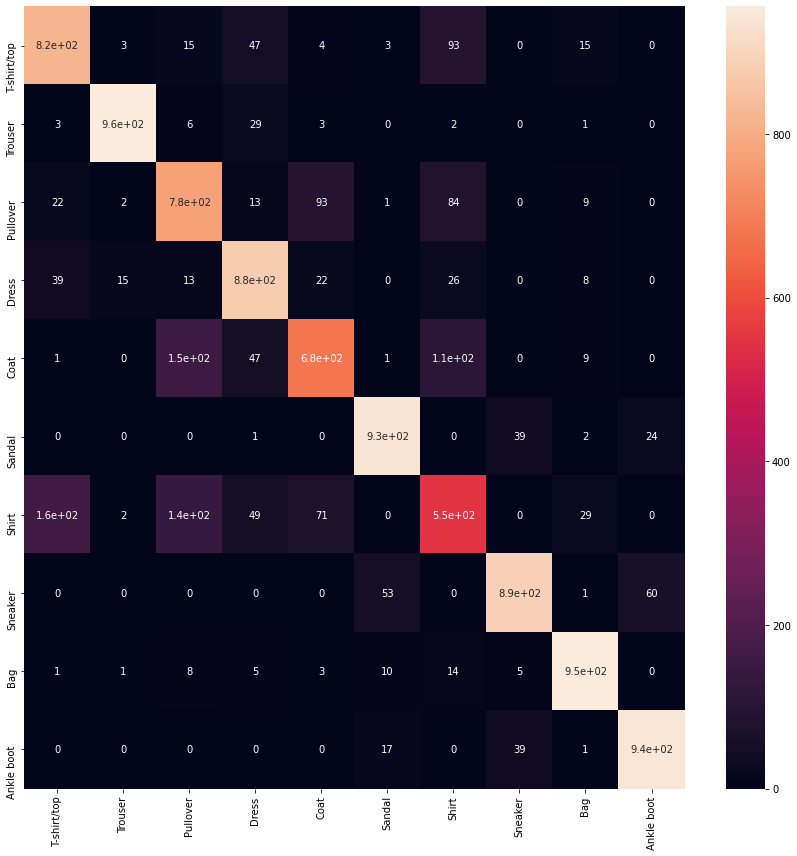

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

df = cfmatrix.copy()
df = np.array(df.values, dtype=np.int32)
fig, ax = plt.subplots(figsize=(12,12)) 
ax = sns.heatmap(df, annot=True, ax=ax)

ax.set_xticklabels(cfmatrix.columns, rotation=90)
ax.set_yticklabels(cfmatrix.index)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90 )
plt.tight_layout()
plt.show()

# Плохие результаты только у класса shirt, они очень похоже на T-Shitr/top и на Pulover.
# Это может быть паолне ожидаемо, т.к. "контуры" этого класса одежды похожи
# Ещё один не лучший результат у Coat по той же причине.

In [186]:
from sklearn.metrics import recall_score, precision_score


recall_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average=None)

array([0.82 , 0.956, 0.776, 0.877, 0.682, 0.934, 0.546, 0.886, 0.953,
       0.943])

In [187]:
precision_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average=None)

array([0.78020932, 0.97650664, 0.6990991 , 0.82116105, 0.77676538,
       0.91658489, 0.62686567, 0.91434469, 0.9270428 , 0.91820837])

In [192]:
cfmatrix.loc[10] = precision_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average=None)

In [194]:
cfmatrix.loc[11] = recall_score(y_test.argmax(axis=1), predictions.argmax(axis=1), average=None)

In [198]:
cfmatrix.rename(index={10: 'precision_score', 11 : 'recall_score'})

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,820.000000,3.000000,15.000000,47.000000,4.000000,3.000000,93.000000,0.000000,15.000000,0.000000
Trouser,3.000000,956.000000,6.000000,29.000000,3.000000,0.000000,2.000000,0.000000,1.000000,0.000000
Pullover,22.000000,2.000000,776.000000,13.000000,93.000000,1.000000,84.000000,0.000000,9.000000,0.000000
Dress,39.000000,15.000000,13.000000,877.000000,22.000000,0.000000,26.000000,0.000000,8.000000,0.000000
Coat,1.000000,0.000000,154.000000,47.000000,682.000000,1.000000,106.000000,0.000000,9.000000,0.000000
Sandal,0.000000,0.000000,0.000000,1.000000,0.000000,934.000000,0.000000,39.000000,2.000000,24.000000
Shirt,165.000000,2.000000,138.000000,49.000000,71.000000,0.000000,546.000000,0.000000,29.000000,0.000000
Sneaker,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000,0.000000,886.000000,1.000000,60.000000
Bag,1.000000,1.000000,8.000000,5.000000,3.000000,10.000000,14.000000,5.000000,953.000000,0.000000
Ankle boot,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,39.000000,1.000000,943.000000


Вывели полноту и точность для каждого класса, добавили в таблицу.

Не удивительно, что для "рубашкоподобной" верхней одежды имеем не высокие результаты, т.к. силуэты этих вещей похожи.

Метрики
https://keras.io/examples/vision/metric_learning/
